In [16]:
from sklearn.datasets import fetch_openml
import pandas as pd
import numpy as np

In [2]:
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [136]:
X, y = mnist['data'], mnist['target']
print(X.shape)
y.shape

(70000, 784)


(70000,)

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt

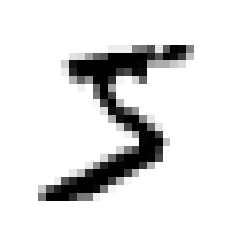

In [13]:
some_digit = X.iloc[0].to_numpy()
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap='binary')
plt.axis('off')
plt.show()

In [14]:
y[0]

'5'

In [18]:
# y를 정수로 변환
y = y.astype(np.uint8)

In [137]:
# Train, Test split
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [22]:
y_train_5 = (y_train==5)
y_test5 = (y_test==5)

In [23]:
# 이진 분류기 훈련
# 확률적 경사 하강법(stochastic Gradient Descent 분류기 사용)
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state = 42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [24]:
# 모델 성능 평가
# 5인 것과 5가 아닌 것을 구분하는 것이기 때문에 정확도 높음
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

In [25]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [26]:
# 이미지의 약 10% 만이 5이기 때문에, 무조건 5가 아니라고 예측하면
# 정확도가 90%에 육박함
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv = 3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

In [27]:
# 이처럼 분류기의 성능 측정 지표로 정확도만을 고집할 시 이와 같은 문제가 발생할 수 있음
# 특히, 불균형한 데이터셋을 다룰 때 더 심함
# ==> 더 좋은 방법은 오차행렬(confusion matrix)를 조사하는 것

In [28]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3)

In [29]:
# 오차행렬의 행 = 실제 값, 열 = 예측값
# 53057 => 5가 아닌 것을 5가 아니라고 예측
# 3530 => 5인 것을 5라고 예측
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

In [30]:
# 완벽한 분류기일 경우
y_train_perpect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perpect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

In [33]:
# 정밀도(precision)와 재현율(recall)
from sklearn.metrics import precision_score, recall_score, f1_score
precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [32]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [55]:
f1_score(y_train_5, y_train_pred)

0.7325171197343846

In [35]:
# 정밀도와 재현율은 트레이드오프 관계에 있음
# 상황마다 무엇을 선호해야 할지는 다를 것
# 도둑을 잡는 분류기를 만든다면, 재현율이 99%라면 정확도가 30%만 되더라도 괜찮을 것
# 종종 경비원이 잘못된 호출을 받겠지만, 거의 모든 도둑을 잡을 것이기 때문

In [36]:
# 임계값을 조정해서 실제 트레이드오프 관계를 확인할 수 있음
# dpredict() 대신, ecision_function()을 사용하면 각 샘플의 점수를 얻을 수 있음
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')

In [37]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

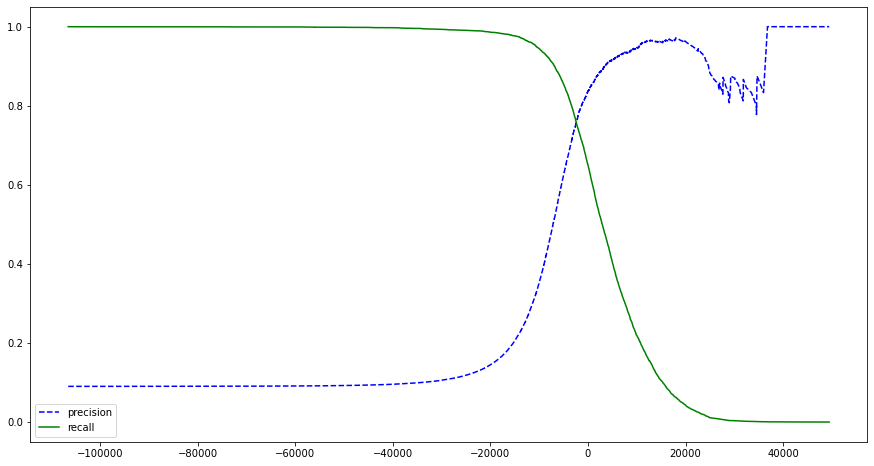

In [46]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize=(15,8))
    plt.plot(thresholds, precisions[:-1], 'b--', label='precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label='recall')

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.legend()
plt.show()

In [50]:
# 이러한 그래프를 보며, 임계값을 정할 수 있음
# 정밀도 90%를 달성하는 것이 목표라면
# 임계값이 약 8000 정도라는 것을 알 수 있음
# 더 정확하게 최소한 90% 정밀도가 되는 가장 낮은 정밀도를 찾으려면
# np.argmax() (최대값의 첫번째 인덱스 반환)을 통해 구할 수 있음

threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision

3370.0194991439557

In [51]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [52]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [53]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

In [54]:
# 정밀도가 90%를 달성한 분류기를 만들었음

In [56]:
# ROC Curve
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

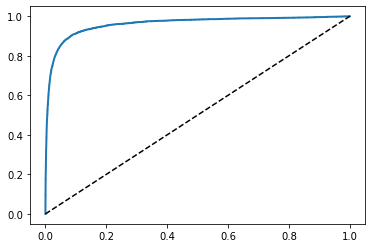

In [57]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')

plot_roc_curve(fpr, tpr)
plt.show()

In [58]:
# AUC 계산
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [59]:
# 다른 분류기로 ROC곡선을 그려 비교해보기
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba')

In [63]:
# roc_curve()는 레이블과 점수를 받음
# 대신에 클래스 확률을 전달해 점수로 사용해보자

y_scores_forest = y_probas_forest[:, 1] # 양성클래스에 대한 확률을 점수로 사용
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

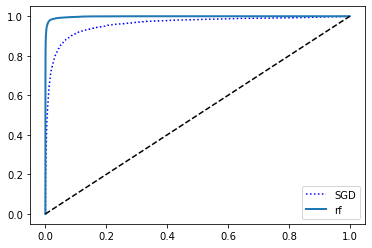

In [66]:
plt.plot(fpr, tpr, 'b:', label='SGD')
plot_roc_curve(fpr_forest, tpr_forest, 'rf')
plt.legend(loc='lower right')
plt.show()

In [68]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [69]:
# 이진분류 = 로지스틱 회귀, 서포트 벡터 머신 등
# 다중 분류 = SGD분류기, 랜덤 포레스트, 나이브 베이즈 등

# 0 ~ 9까지 분류할 때,
# OvR = 0 ~ 9까지 분류기의 점수 중 가장 높은 것을 선택
# OvO = 0과1 구별, 0과 2 구별 등 모든 두가지의 조합마다 훈련하고
# 10*9/2 즉, 45개의 분류기를 모두 통과시켜 가장 많이 양성으로 나온 분류기를 선택(주로 SVM)

In [70]:
# SVM 분류기 테스트
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [73]:
svm_clf.decision_function([some_digit])

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [72]:
# SGD 분류기 테스트
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [74]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [76]:
# SGD 분류기 교차 검정(accuracy)
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

array([0.87365, 0.85835, 0.8689 ])

In [77]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

array([0.87365, 0.85835, 0.8689 ])

In [80]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]],
      dtype=int64)

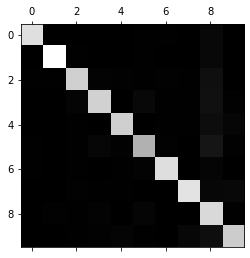

In [81]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [84]:
# 대부분의 이미지가 올바르게 분류되었음을 의미하는 주대각선에 있으므로 매우 좋아보임
# 하지만, 숫자 5는 다른 숫자보다 어두움 ==> 이는 숫자 5의 이미지가 적거나, 숫자 5를 다른 숫자만큼 잘 분류하지 못한다는 의미
## 에러 부분에 초점을 맞춰, 오차 행렬의 각 값을 대응되는 클래스의 이미지 개수로 나누어 에러비율을 비교

row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

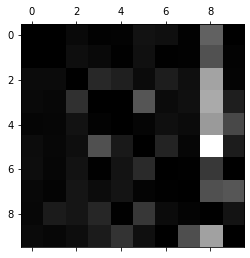

In [87]:
# 다른 항목은 그대로 유지하고 주대각선만 0으로 채워서 그래프를 그려보자

np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

In [88]:
# 많은 이미지가 8로 잘못 분류되었음을 알 수 있지만
# 클래스 8은 분류가 잘 된 모습임 ==> 대칭적이지만은 않음
# ==> 8로 잘못 분류되는 것을 줄이도록 개선할 필요가 있어 보임
## => 8처럼 보이는(실제 8은 아닌) 데이터를 추가해서 학습시키거나, 분류기에 도움이 될 만한 특성을 찾는 것

In [114]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = plt.cm.binary, **options)
    plt.axis("off")

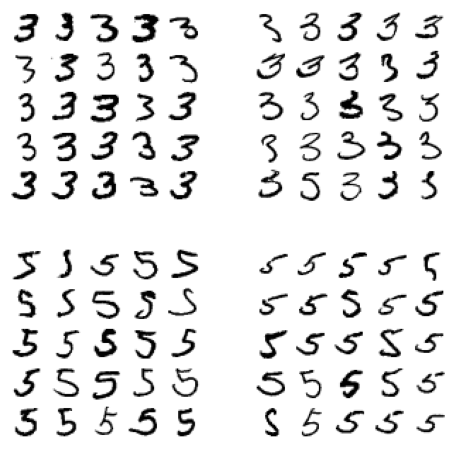

In [116]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train==cl_a)&(y_train_pred==cl_a)]
X_ab = X_train[(y_train==cl_a)&(y_train_pred==cl_b)]
X_ba = X_train[(y_train==cl_b)&(y_train_pred==cl_a)]
X_bb = X_train[(y_train==cl_b)&(y_train_pred==cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25].values, images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25].values, images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25].values, images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25].values, images_per_row=5)
plt.show()

In [117]:
# 왼쪽 두 개는 3으로 분류된 이미지  오른쪽 두 개는 5로 분류된 이미지
# SGD는 선형모델이며, 픽셀마다 가중치를 할당해 픽셀 강도의 가중치 합을 클래스의 점수로 계산함
# 3과 5는 몇 개의 픽셀만 다르기 때문에 모델이 쉽게 혼동하게 됨
# 3과 5를 구별하는 것은 위와 아래를 연결하는 직선의 위치
## ==> 회전이나 방향에 매우 민감함
## ==> 이미지를 중앙에 위치시키고, 회전되어 있지 않도록 전처리하면 에러가 줄어들 것임

In [118]:
# 다중 레이블 분류
# 모든 분류기가 다중레이블을 지원하는 것은 아님
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >=7)
y_train_odd = (y_train%2==1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [119]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [120]:
# 다중 레이블 분류 평가
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average='macro')

0.976410265560605

In [121]:
# 다중 레이블 분류 평가
# 레이블의 불균형을 제대로 평가하기 위해 샘플수를 토대로 가중치 부여
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average='weighted')

0.9778357403921755

In [125]:
# 다중 출력 분류 = 다중 레이블 분류에서 한 레이블이 다중 클래스가 될 수 있도록 일반화 한 것
# 이 문제는 앞서 말한 분류기들의 일반화버전이라고 볼 수 있으며, input, ouput이 모두 그 크기의 array로 들어옴으로써 그 값을 처리하고 출려해주는 형식이라고 생각하면 된다.
noise = np.random.randint(0,100,(len(X_train),784))
X_train_mod = X_train+noise
noise = np.random.randint(0,100,(len(X_test),784))
X_test_mod = X_test+noise
y_train_mod = X_train
y_test_mod = X_test

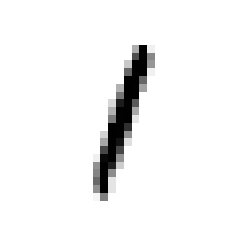

In [133]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod.iloc[5]])
plot_digits(clean_digit)